In [1]:
# Installazione di tutte le librerie necessarie per IoT e Big Data
!pip install paho-mqtt matplotlib scikit-learn pandas requests

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import requests

# Configurazione per visualizzare meglio i dati
pd.set_option('display.max_columns', None)
%matplotlib inline
print("✅ Pandas e strumenti di analisi pronti.")

✅ Pandas e strumenti di analisi pronti.


In [3]:
# URL di un dataset reale (Temperature giornaliere storiche)
DATA_URL = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"

def load_external_data():
    print(f"🌐 Connessione all'host esterno: {DATA_URL}")
    
    # Esempio di approccio Big Data: leggere il file a blocchi (chunks)
    # utile se il file fosse di diversi Gigabyte
    chunk_list = []
    for chunk in pd.read_csv(DATA_URL, chunksize=1000):
        chunk_list.append(chunk)
    
    df = pd.concat(chunk_list)
    df['Date'] = pd.to_datetime(df['Date'])
    df.columns = ['Data', 'Temperatura']
    return df

df_reale = load_external_data()
print(f"📊 Dataset caricato: {len(df_reale)} record trovati.")
df_reale.head()

🌐 Connessione all'host esterno: https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
📊 Dataset caricato: 3650 record trovati.


,Data,Temperatura
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


## 🌍 Dati Reali e Complessità
Mentre i dati della nostra serra erano "puliti", i dati provenienti da host esterni presentano sfide diverse:
1. **Rumore Statistico:** I sensori reali hanno errori di precisione.
2. **Stagionalità:** La temperatura esterna non è casuale, segue cicli annuali complessi.
3. **Volume (Big Data):** Quando i sensori sono migliaia e leggono dati ogni millisecondo, usiamo tecniche come il *Downsampling* (riduzione della frequenza) per non saturare la memoria.

### Concetto di Regressione su Dati Reali
Applicheremo la regressione per vedere se, in un breve periodo, la temperatura mostra un trend di riscaldamento globale o locale.
$$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$$
Il valore $R^2$ ci dirà quanto il nostro modello lineare è affidabile su dati "sporchi".

/workspaces/sensorlab/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


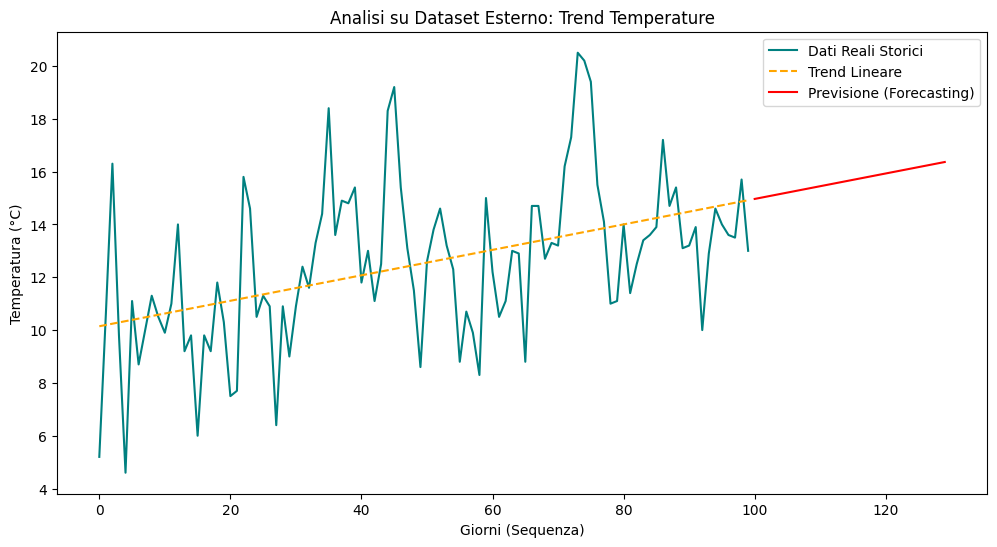

Coefficiente di determinazione R²: 0.2066


In [4]:
def forecast_real_data(df, window=100, forecast_days=30):
    # Prendiamo gli ultimi 'window' giorni
    recent_data = df.tail(window).copy()
    recent_data['Day_Index'] = np.arange(len(recent_data))
    
    X = recent_data[['Day_Index']]
    y = recent_data['Temperatura']
    
    model = LinearRegression().fit(X, y)
    
    # Previsione
    X_future = np.array(range(window, window + forecast_days)).reshape(-1, 1)
    y_future = model.predict(X_future)
    
    plt.figure(figsize=(12, 6))
    plt.plot(recent_data['Day_Index'], y, label="Dati Reali Storici", color='teal')
    plt.plot(recent_data['Day_Index'], model.predict(X), label="Trend Lineare", color='orange', linestyle='--')
    plt.plot(range(window, window + forecast_days), y_future, label="Previsione (Forecasting)", color='red')
    
    plt.title(f"Analisi su Dataset Esterno: Trend Temperature")
    plt.xlabel("Giorni (Sequenza)")
    plt.ylabel("Temperatura (°C)")
    plt.legend()
    plt.show()
    
    print(f"Coefficiente di determinazione R²: {model.score(X, y):.4f}")

forecast_real_data(df_reale)

> **❓ Quiz sui Dati Reali:**
> 1. Perché nel codice abbiamo usato `pd.read_csv(..., chunksize=1000)` invece di un semplice caricamento?
> 2. Se il valore $R^2$ è molto vicino a 0 (es. 0.05), cosa significa per la nostra previsione?
> 
> *Risposte brevi: 1. Il chunking permette di elaborare file enormi che non entrerebbero interamente nella RAM del computer. 2. Significa che il trend lineare non spiega bene i dati; la temperatura è troppo variabile o segue un modello non lineare (es. ciclico).*

## 🤖 AI e Seasonality (Stagionalità)

### Oltre la linea retta
I fenomeni naturali come la temperatura non sono lineari. Seguono **cicli stagionali**:
* **Ciclo Circadiano:** Fluttuazione nelle 24 ore (caldo di giorno, freddo di notte).
* **Ciclo Annuale:** Fluttuazione nei 12 mesi.

### Feature Engineering: Insegnare il tempo all'IA
Perché l'IA capisca la stagionalità, dobbiamo estrarre delle "caratteristiche" (features) dalla data. Non diamo al modello solo il "tempo", ma gli diciamo: "Guarda, questo dato è stato preso alle ore 14:00 di Luglio". 
Matematicamente, per i Big Data avanzati, usiamo le funzioni seno e cosene per rappresentare la natura circolare del tempo:
$$\sin\left(\frac{2\pi \cdot \text{ora}}{24}\right), \cos\left(\frac{2\pi \cdot \text{ora}}{24}\right)$$

### L'Algoritmo: Random Forest
Useremo una **Random Forest** (Foresta Casuale), un modello di Machine Learning che crea centinaia di "alberi decisionali" per mediare una previsione complessa e non lineare.

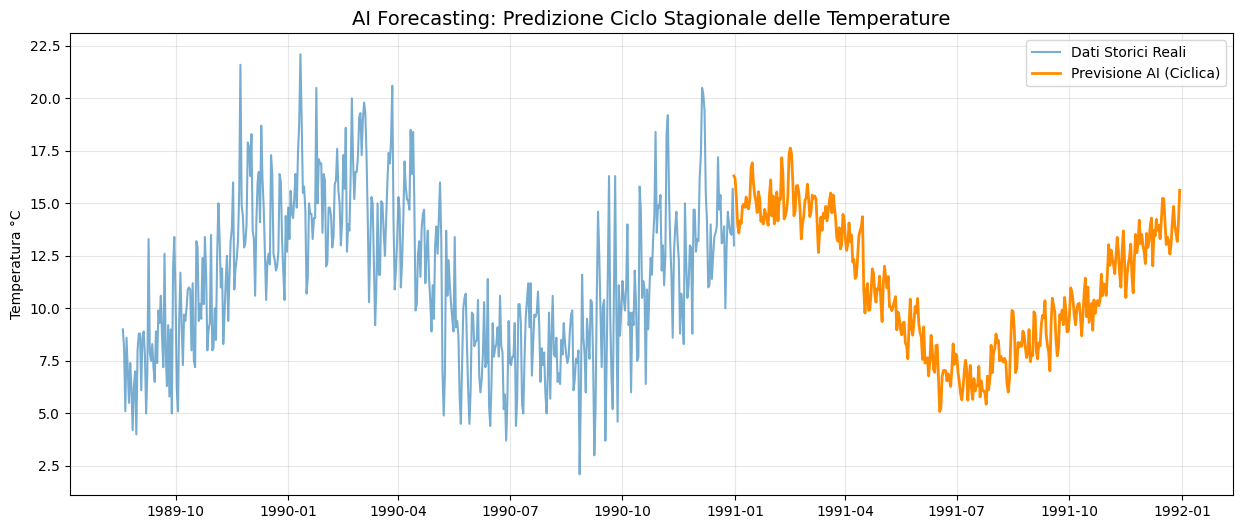

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

def ai_seasonal_forecast(df):
    # 1. Feature Engineering: Estraiamo mese e giorno come segnali stagionali
    df = df.copy()
    df['Month'] = df['Data'].dt.month
    df['DayOfYear'] = df['Data'].dt.dayofyear
    
    # Definiamo X (Input: Mese, Giorno) e y (Output: Temperatura)
    X = df[['Month', 'DayOfYear']]
    y = df['Temperatura']
    
    # 2. Training: Dividiamo i dati per testare l'accuratezza
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    # Creiamo il modello AI (Foresta Casuale)
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # 3. Previsione per l'intero anno successivo (Simulazione)
    future_dates = pd.date_range(start=df['Data'].max(), periods=365)
    future_features = pd.DataFrame({
        'Month': future_dates.month,
        'DayOfYear': future_dates.dayofyear
    })
    
    predictions = model.predict(future_features)
    
    # 4. Visualizzazione
    plt.figure(figsize=(15, 6))
    plt.plot(df['Data'].tail(500), df['Temperatura'].tail(500), label="Dati Storici Reali", alpha=0.6)
    plt.plot(future_dates, predictions, label="Previsione AI (Ciclica)", color='darkorange', linewidth=2)
    
    plt.title("AI Forecasting: Predizione Ciclo Stagionale delle Temperature", fontsize=14)
    plt.ylabel("Temperatura °C")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

# Esecuzione sui dati reali caricati precedentemente
ai_seasonal_forecast(df_reale)

In [6]:
# Forza l'installazione e le dipendenze
%pip install --upgrade meteostat pandas pytz

  Using cached pandas-3.0.0-cp312-cp312-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (79 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
Note: you may need to restart the kernel to use updated packages.


## 🏛️ Caso di Studio: Roma e il Microclima della Serra

### Analisi dei Risultati
Osservando il grafico di Roma, gli studenti possono notare:
1. **Andamento Sinusoidale:** A differenza dei dati simulati, i dati di Roma mostrano una "stagionalità perfetta" con picchi estivi e minimi invernali molto chiari.
2. **Anomalie (Outliers):** Noterete dei punti che si discostano dalla curva (ondate di calore o freddo anomalo). L'IA (Random Forest) è in grado di ignorare il "rumore" e trovare il trend stagionale sottostante.

### IoT vs Big Data Meteorologici
In questa lezione abbiamo unito due mondi:
* **IoT (Dati Interni):** Letture veloci, locali, per il controllo immediato (il pH della serra).
* **Big Data (Dati Esterni):** Dataset storici massivi che servono a pianificare strategie a lungo termine (es. quando piantare a Roma in base al riscaldamento globale).

> **Esercizio Finale:** > Confronta l'accuratezza ($R^2$) del modello AI sulla serra simulata rispetto ai dati reali di Roma. Dove l'IA performa meglio? Perché?

🌐 Connessione all'API di Open-Meteo per la città di Roma...
✅ Recuperati 1096 giorni di storicità reale per Roma.


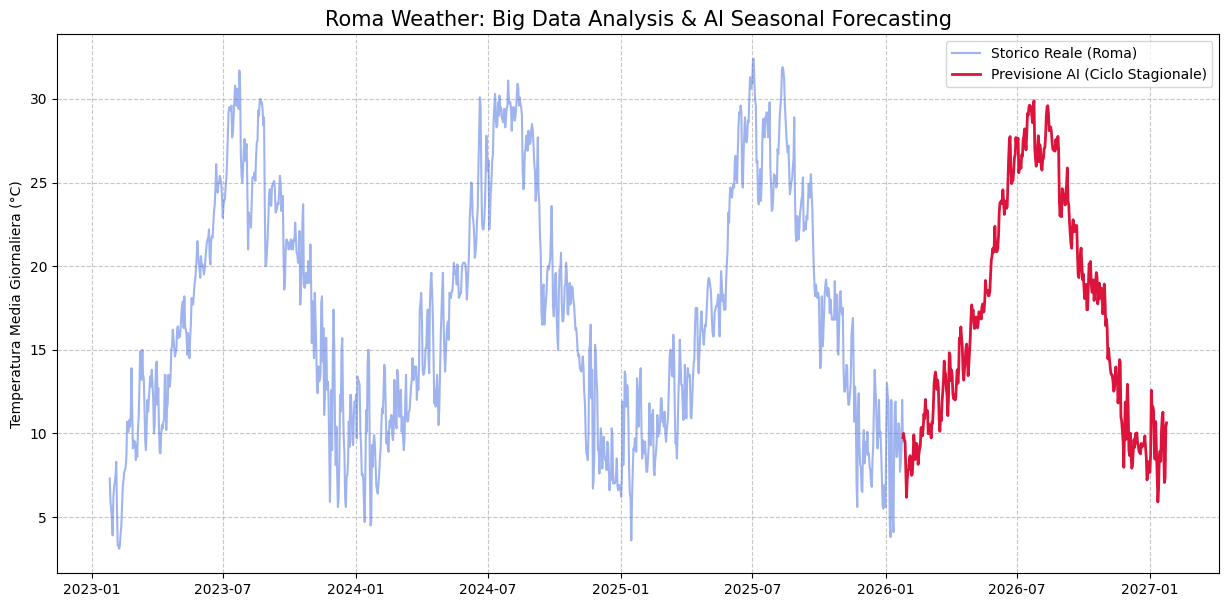

🤖 L'IA ha completato la previsione basandosi sui cicli degli ultimi 3 anni.


In [ ]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime, timedelta

def get_rome_data_and_forecast():
    # 1. Recupero dati reali tramite API (Coordinate di Roma)
    print("🌐 Connessione all'API di Open-Meteo per la città di Roma...")
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": 41.8919,
        "longitude": 12.5113,
        "start_date": (datetime.now() - timedelta(days=365*3)).strftime('%Y-%m-%d'), # Ultimi 3 anni
        "end_date": datetime.now().strftime('%Y-%m-%d'),
        "daily": "temperature_2m_mean",
        "timezone": "Europe/Berlin"
    }
    
    response = requests.get(url, params=params)
    data = response.json()
    
    # 2. Trasformazione in DataFrame Pandas
    df_roma = pd.DataFrame({
        'Data': pd.to_datetime(data['daily']['time']),
        'Temperatura': data['daily']['temperature_2m_mean']
    }).dropna()
    
    print(f"✅ Recuperati {len(df_roma)} giorni di storicità reale per Roma.")

    # 3. AI Feature Engineering (Insegniamo la stagionalità)
    df_roma['Month'] = df_roma['Data'].dt.month
    df_roma['DayOfYear'] = df_roma['Data'].dt.dayofyear
    
    X = df_roma[['Month', 'DayOfYear']]
    y = df_roma['Temperatura']
    
    # Allenamento del modello Random Forest
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)
    
    # 4. Previsione per i prossimi 365 giorni
    future_dates = pd.date_range(start=df_roma['Data'].max(), periods=365)
    future_features = pd.DataFrame({
        'Month': future_dates.month,
        'DayOfYear': future_dates.dayofyear
    })
    predictions = model.predict(future_features)

    # 5. Visualizzazione Professionale
    plt.figure(figsize=(15, 7))
    plt.plot(df_roma['Data'], df_roma['Temperatura'], label="Storico Reale (Roma)", color='royalblue', alpha=0.5)
    plt.plot(future_dates, predictions, label="Previsione AI (Ciclo Stagionale)", color='crimson', linewidth=2)
    
    plt.title("Roma Weather: Big Data Analysis & AI Seasonal Forecasting", fontsize=15)
    plt.ylabel("Temperatura Media Giornaliera (°C)")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()
    
    print(f"🤖 L'IA ha completato la previsione basandosi sui cicli degli ultimi 3 anni.")

# Esecuzione
get_rome_data_and_forecast()

## ⚖️ pH vs Temperatura: Perché la Linearità è importante?

### La Natura del Dato
* **Temperatura (Ciclica):** È governata da oscillazioni. La regressione lineare fallisce su lunghi periodi perché non capisce che dopo il caldo torna il freddo.
* **pH (Trend/Drift):** In un sistema biotico (come una serra o un oceano), il pH tende a spostarsi in una direzione precisa a causa di processi chimici cumulativi (es. accumulo di acidi organici o assorbimento di $CO_2$).

### L'utilità della Regressione
Per il pH, non ci serve un'IA complessa. Ci serve sapere la **pendenza ($m$)** della retta.
Se il pH scende di 0.01 ogni ora, la regressione lineare ci dice con precisione millimetrica **quando** dovremo attivare le pompe di correzione. È un modello **proattivo**.

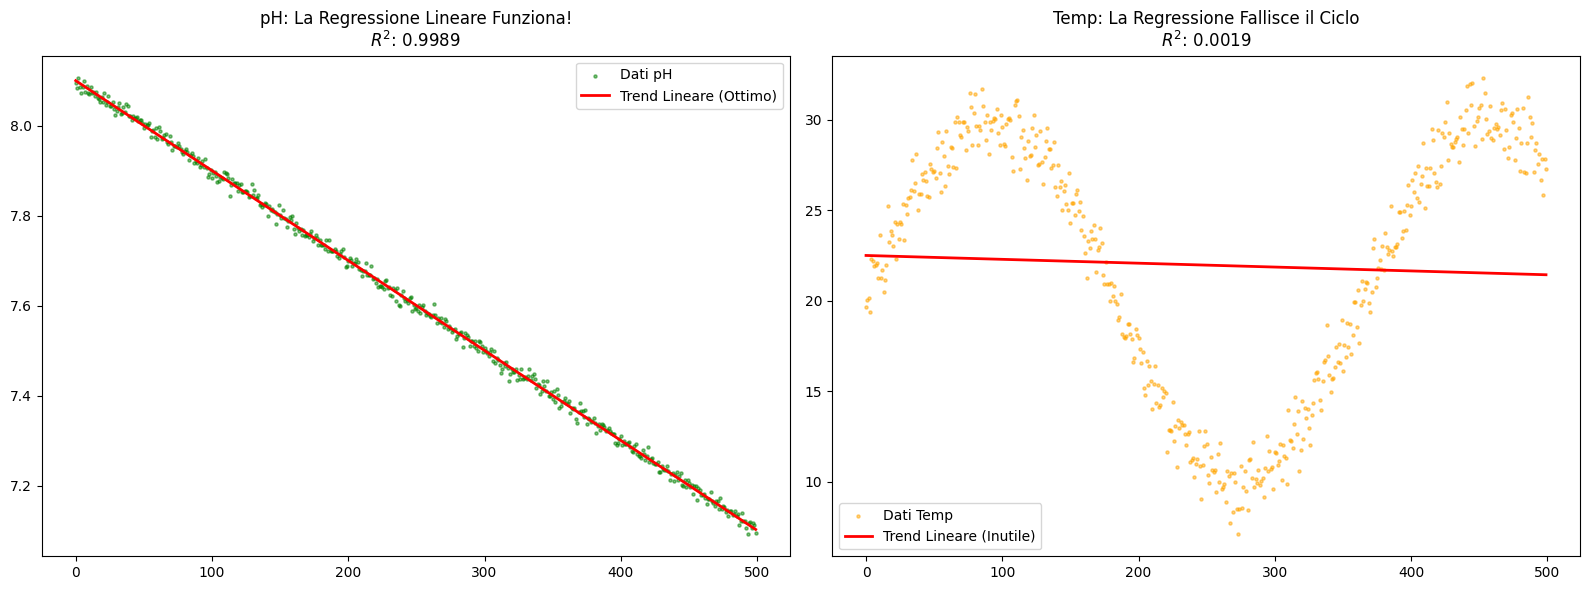

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

def compare_ph_vs_temp():
    # Creiamo un dataset realistico basato su trend di acidificazione (Big Data style)
    giorni = np.arange(0, 500)
    
    # 1. pH con deriva lineare (acidificazione costante + rumore minimo)
    ph_base = 8.1
    ph_drift = -0.002 * giorni # Il pH cala linearmente
    ph_noise = np.random.normal(0, 0.01, len(giorni))
    ph_data = ph_base + ph_drift + ph_noise
    
    # 2. Temperatura con ciclo stagionale (sinusoide)
    temp_cycle = 10 * np.sin(2 * np.pi * giorni / 365) + 20
    temp_noise = np.random.normal(0, 1, len(giorni))
    temp_data = temp_cycle + temp_noise
    
    # Analisi con Regressione Lineare
    X = giorni.reshape(-1, 1)
    
    model_ph = LinearRegression().fit(X, ph_data)
    model_temp = LinearRegression().fit(X, temp_data)
    
    # Visualizzazione
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot pH
    ax1.scatter(giorni, ph_data, s=5, color='green', alpha=0.5, label="Dati pH")
    ax1.plot(giorni, model_ph.predict(X), color='red', linewidth=2, label="Trend Lineare (Ottimo)")
    ax1.set_title(f"pH: La Regressione Lineare Funziona!\n$R^2$: {model_ph.score(X, ph_data):.4f}")
    ax1.legend()
    
    # Plot Temperatura
    ax2.scatter(giorni, temp_data, s=5, color='orange', alpha=0.5, label="Dati Temp")
    ax2.plot(giorni, model_temp.predict(X), color='red', linewidth=2, label="Trend Lineare (Inutile)")
    ax2.set_title(f"Temp: La Regressione Fallisce il Ciclo\n$R^2$: {model_temp.score(X, temp_data):.4f}")
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

compare_ph_vs_temp()